## Image Mosaicing 
<ul>
<li>Imaging mosaicing is Process to combine the parts of same image and create final image such that final image looks like the original combined image.</li>
<br>
<li> <b>Main 3 steps are involved in image mosaicing</b></li>
    <ol>
        <li> Feature Extraction </li>
        <li> Homography Computation </li>
        <li> Image Wrapping </li>
    </ol>
</ul>

## Imports 

In [3]:
import time 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random 

### 1. Extract Features:


*   <b>SIFT features :</b> <br> Detects salient, stable feature points in an image and provides a set of feature vector that characterize/describe a small image region around the point. These features are invariant to rotation and scale.



In [1]:
def good_matches(img1, img2):
    
    sift = cv2.xfeatures2d.SIFT_create()
    
    k1, d1 = sift.detectAndCompute(img1, None)
    k2, d2 = sift.detectAndCompute(img2, None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(d1, d2, k=2)
    
    goodMatches = []
    for m, n in matches:
        if (m.distance/n.distance) < 0.3:
            goodMatches.append(m)
    
    return k1, k2, goodMatches

### 2. Computing Homography 
<ul>

<li><b>Feature Matching with Brute-Force Matcher :</b><br> To match feature points between two images. SIFT and SURF descriptors represent the histogram of oriented gradient (of the Haar wavelet response for SURF) in a neighborhood and hence require histogram-based metrics for matching. Using KNN (k=2 here) finds the k best matches for each descriptor from a query set.</li><br>

<li><b>Find homography matrix :</b><br> 
Homography is mapping between two spaces which often used to represent the correspondence
between two images of the same scene. It’s widely useful for images where multiple images are
taken from a rotating camera having a fixed camera centre ultimately warped together to produce
a panoramic view    
    
Find homography matrix using DLT based method which uses RANSAC to iteratively find best set of points among available for finding matrix.</li>

</ul>

PH = 0 = \begin{bmatrix}
-x_1 \quad -y_1 \quad -1 \quad 0 \quad 0 \quad 0 \quad x_1x_1' \quad y_1x_1' \quad x_1' \\
0 \quad 0 \quad 0 \quad -x_1 \quad -y_1 \quad -1 \quad x_1y_1' \quad y_1y_1' \quad y_1' \\
-x_2 \quad -y_2 \quad -1 \quad 0 \quad 0 \quad 0 \quad x_2x_2' \quad y_2x_2' \quad x_2' \\
0 \quad 0 \quad 0 \quad -x_2 \quad -y_2 \quad -1 \quad x_2y_2' \quad y_2y_2' \quad y_2' \\
-x_3 \quad -y_3 \quad -1 \quad 0 \quad 0 \quad 0 \quad x_3x_3' \quad y_3x_3' \quad x_3' \\
0 \quad 0 \quad 0 \quad -x_3 \quad -y_3 \quad -1 \quad x_3y_3' \quad y_3y_3' \quad y_3' \\
-x_4 \quad -y_4 \quad -1 \quad 0 \quad 0 \quad 0 \quad x_4x_4' \quad y_4x_4' \quad x_4' \\
0 \quad 0 \quad 0 \quad -x_4 \quad -y_4 \quad -1 \quad x_4y_4' \quad y_4y_4' \quad y_4' \\
\end{bmatrix} 
\begin{bmatrix}h1 \\ h2 \\ h3 \\ h4 \\ h5 \\ h6 \\ h7 \\ h8 \\h9 \end{bmatrix}

In [2]:

def find_homography(src, dst, iters=500, ths=5):
    
    src = np.concatenate((src, np.ones((src.shape[0], 1))), axis=1)
    
    max_count = 0
    
    for i in range(iters):
        
        idx = np.random.randint(src.shape[0], size=4)
        temp_src = src[idx]
        temp_dst = dst[idx]

        ax = np.concatenate((-temp_src, np.zeros((4, 3)), temp_dst[:, 0:1]*temp_src), axis=1)
        ay = np.concatenate((np.zeros((4, 3)), -temp_src, temp_dst[:, 1:]*temp_src), axis=1)
        
        M = np.concatenate((ax, ay), axis=0)
        U, S, V = np.linalg.svd(M)
        
        H = V[8].reshape(3, 3)
        
        temp_count = 0
        
        res = src.dot(H.T)
        res = np.divide(res, res[:, 2].reshape(-1, 1))
        
        error = np.linalg.norm(res[:, :2] - dst, axis=1)
        
        temp_count = np.count_nonzero( error < ths )

        if temp_count > max_count:
            best_H = H
            max_count = temp_count
    
    return best_H


### 3. Perspactive Transform 

<ul>
<li>Once an accurate homography has been calculated, the transformation can be applied to all pixels in one image to map it to the other image. This is done using the warpPerspective function in OpenCV</li>
<br>
<li>   After obtaining homography matrix apply a perspective transformation to image using 3x3 homography matrix which finds the target pixel as</li>

</ul>
\begin{equation}
\texttt{dst} (x,y) = \texttt{src} \left ( \frac{M_{11} x + M_{12} y + M_{13}}{M_{31} x + M_{32} y + M_{33}} , \frac{M_{21} x + M_{22} y + M_{23}}{M_{31} x + M_{32} y + M_{33}} \right )
\end{equation}


In [ ]:
def expand_img(img):
    for i in range(0, img.shape[0]):
        if (img[i] != 0).any():
            img = img[i:]
            break
            
    for i in range(img.shape[0]-1, 0, -1):
        if (img[i] != 0).any():
            img = img[:i]
            break
    
    for i in range(img.shape[1]-1, 0, -1):
        if (img[:, i] != 0).any():
            img = img[:, :i]
            break
            
    for i in range(0, img.shape[1]):
        if (img[:, i] != 0).any():
            img = img[:, i:]
            break
            
    return img


def image_mosaicing(img1, img2):
    
    final_img = np.pad(img1, ((img1.shape[0], img1.shape[0]), (img1.shape[1], img1.shape[1]), (0, 0)), 'constant')
 
    k1, k2, goodMatches = good_matches(final_img, img2)
    
    if len(goodMatches) < 5:
        print('Cannot find homography matrix , Less then 5 matching points')
        return None
    
    src_pts = []
    dst_pts = []
    
    for i in range(len(goodMatches)):
        src_pts.append( [ k2[ goodMatches[i].trainIdx ].pt[0], k2[ goodMatches[i].trainIdx ].pt[1]] )
        dst_pts.append( [ k1[ goodMatches[i].queryIdx ].pt[0], k1[ goodMatches[i].queryIdx ].pt[1]] )
    
    src_pts = np.array(src_pts)
    dst_pts = np.array(dst_pts)
    
    H = find_homography(src_pts, dst_pts)
    
    warped = cv2.warpPerspective(img2, H, (final_img.shape[1], final_img.shape[0]))
    
    warped[final_img!=0] = 0
    
    final = expand_img(warped + final_img)
    
    return final 

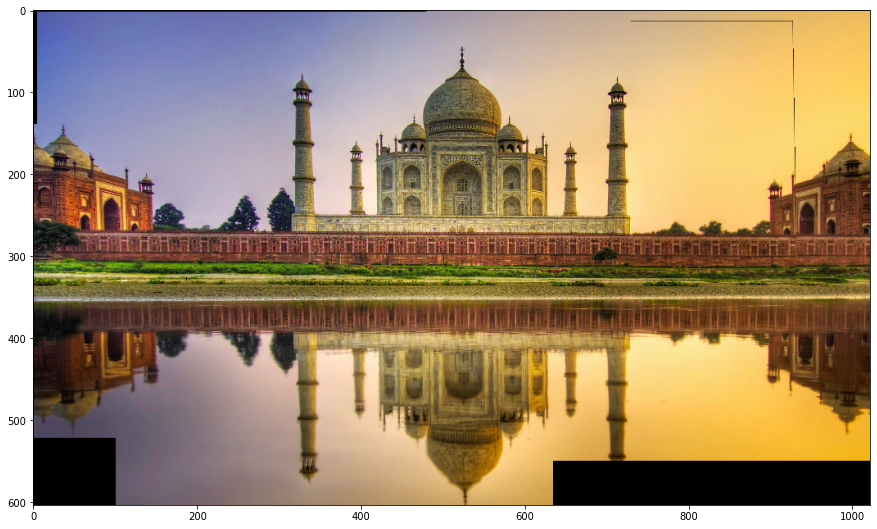

In [30]:
img1 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/2_1.png'),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/2_2.png'),cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/2_3.png'),cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/2_4.png'),cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/2_5.png'),cv2.COLOR_BGR2RGB)
img6 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/2_6.png'),cv2.COLOR_BGR2RGB)

op1 = image_mosaicing(img1 ,img2)
op2 = image_mosaicing(op1 ,img3)

op3 = image_mosaicing(img4 ,img5)
op4 = image_mosaicing( op3 ,img6)

op = image_mosaicing(op2 ,op4)

plt.figure(figsize=(15,15))
plt.imshow(op)

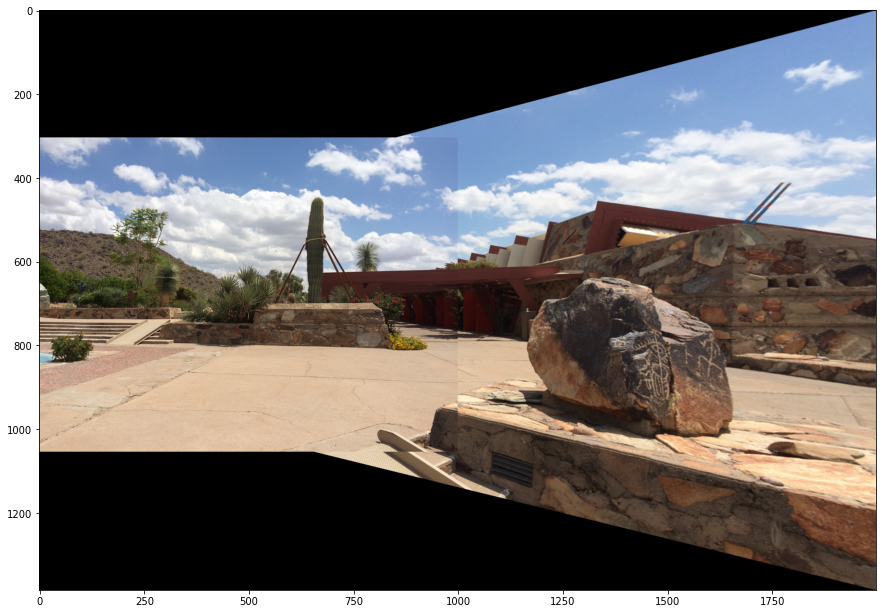

In [14]:
img1 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/3_1.png'),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/3_2.png'),cv2.COLOR_BGR2RGB)

final = image_mosaicing(img1, img2)
plt.figure(figsize=(15,15))
plt.imshow(final)

In [28]:
img1 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/4_1.jpg'),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/4_2.jpg'),cv2.COLOR_BGR2RGB)

final = image_mosaicing(img1, img2)

if final != None:
    plt.figure(figsize=(15,15))
    plt.imshow(final)

Cannot find homography matrix , Less then 5 matching points


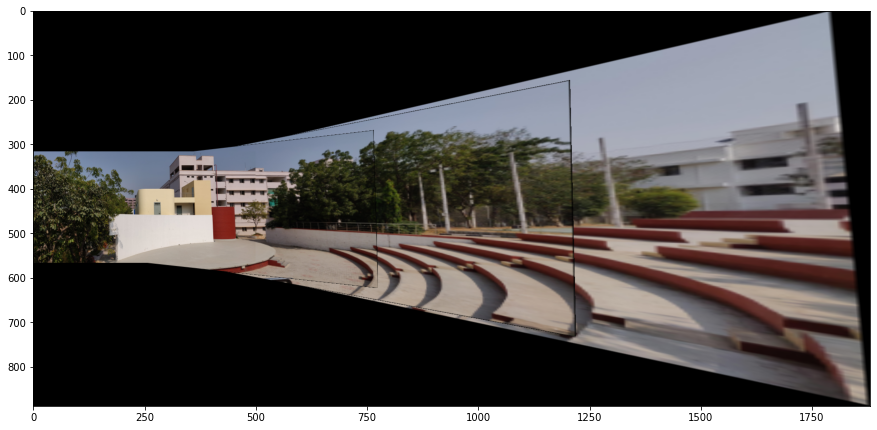

In [16]:
newsize = (500, 250) 

img1 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/1_1.jpg'),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/1_2.jpg'),cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/1_3.jpg'),cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/1_4.jpg'),cv2.COLOR_BGR2RGB)

img1 = cv2.resize(img1, newsize, interpolation = cv2.INTER_AREA)
img2 = cv2.resize(img2, newsize, interpolation = cv2.INTER_AREA)
img3 = cv2.resize(img3, newsize, interpolation = cv2.INTER_AREA)
img4 = cv2.resize(img4, newsize, interpolation = cv2.INTER_AREA)


op1 = image_mosaicing(img1 ,img2)
op2 = image_mosaicing(op1 ,img3)
final = image_mosaicing(op2 ,img4)

plt.figure(figsize=(15,15))
plt.imshow(final)

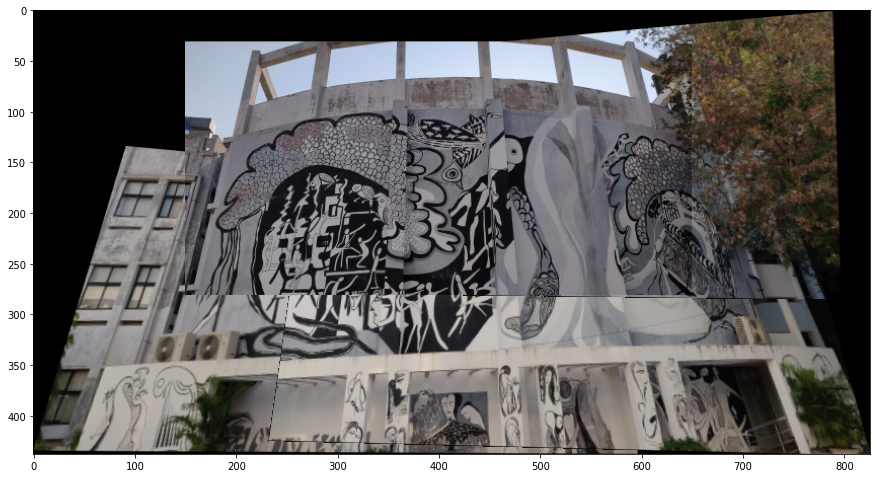

In [17]:
img1 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/5_1.jpg'),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/5_2.jpg'),cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/5_3.jpg'),cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/5_4.jpg'),cv2.COLOR_BGR2RGB)

img1 = cv2.resize(img1, newsize, interpolation = cv2.INTER_AREA)
img2 = cv2.resize(img2, newsize, interpolation = cv2.INTER_AREA)
img3 = cv2.resize(img3, newsize, interpolation = cv2.INTER_AREA)
img4 = cv2.resize(img4, newsize, interpolation = cv2.INTER_AREA)

op1 = image_mosaicing(img1 ,img2)
op2 = image_mosaicing(op1 ,img3)
final = image_mosaicing(op2 ,img4)

plt.figure(figsize=(15,15))
plt.imshow(final)

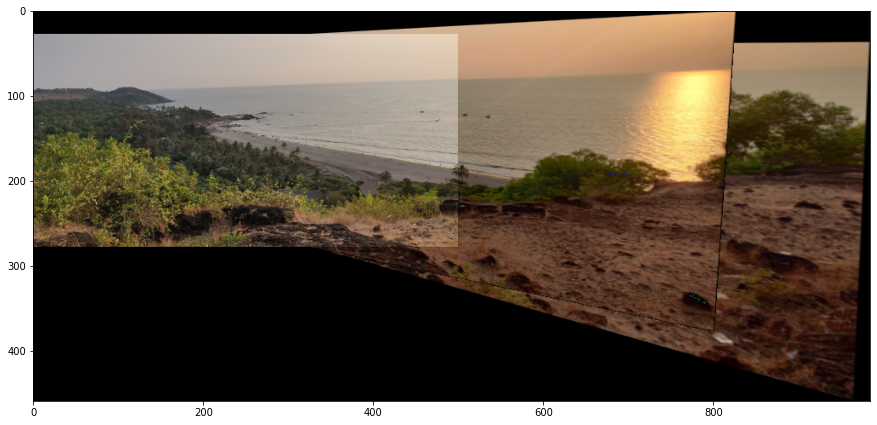

In [33]:
img1 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/0_1.jpg'),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/0_2.jpg'),cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(cv2.imread('../images/Image Mosaicing/0_3.jpg'),cv2.COLOR_BGR2RGB)


img1 = cv2.resize(img1, newsize, interpolation = cv2.INTER_AREA)
img2 = cv2.resize(img2, newsize, interpolation = cv2.INTER_AREA)
img3 = cv2.resize(img3, newsize, interpolation = cv2.INTER_AREA)

op1 = image_mosaicing(img1 ,img2)
op2 = image_mosaicing(op1 ,img3)

plt.figure(figsize=(15,15))
plt.imshow(op2)